# Setup

In [1]:
%pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import math
import time
import psutil
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
random_seed = 42

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(random_seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

using cuda


# Data Pre-Processing

In [4]:
# dataset_path = '/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/'
dataset_path = '/notebooks/dataset/'

In [5]:
def compute_path_lengths(data):
    longest_path = 0
    shortest_path = float('inf')
    average_paths = []

    # Check if the data is a single graph or a dataset of graphs
    if isinstance(data, list) or isinstance(data, DataLoader):
        graphs = data
    else:
        graphs = [data]

    for graph in graphs:
        G = to_networkx(graph, to_undirected=True)
        
        # Compute shortest path lengths
        path_lengths = dict(nx.all_pairs_shortest_path_length(G))
        graph_longest_path = 0
        graph_total_path_length = 0
        graph_total_paths = 0
        
        for lengths in path_lengths.values():
            for length in lengths.values():
                if length > graph_longest_path:
                    graph_longest_path = length
                if length < shortest_path:
                    shortest_path = length
                graph_total_path_length += length
                graph_total_paths += 1

        # Update the overall longest path
        if graph_longest_path > longest_path:
            longest_path = graph_longest_path

        # Calculate the average path length for this graph
        if graph_total_paths > 0:
            graph_average_path = graph_total_path_length / graph_total_paths
            average_paths.append(graph_average_path)
    
    overall_average_path = np.mean(average_paths) if average_paths else 0
    std_average_path = np.std(average_paths) if average_paths else 0
    shortest_path = shortest_path if shortest_path != float('inf') else 0
    
    return int(longest_path), int(shortest_path), overall_average_path, std_average_path

def multivariate_simulate(datapath, n_samples=200,n_time=2,n_views=4):
    # Note that changing the node count is not provided right now, since we use correlation matrix
    # and the mean values of connectivities from real data and it is for 35 nodes.
    
    # Import all required statistical information.
    allstats = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Connectivity mean values of LH. You can also try with RH.
    allcorrs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # Correlation matrix in LH. You can also try with RH.
    all_diffs = np.load(datapath + "stats/REAL_TIME_DIFF.npy") # This is an overall representation of time differences in both (LH and RH) datasets.
    
    times = []
    for t in range(n_time):
        views = []
        for v in range(n_views):
            # Note that we randomly assign a new random state to ensure it will generate a different dataset at each run.
            # Generate data with the correlations and mean values at the current timepoint.
            if t < 2:
                connectomic_means = allstats[t,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[t,v],n_samples,random_state=randint(1,9999))
            # If the requested timepoints are more than we have in real data, use the correlation information from the last timepoint.
            else:
                connectomic_means = allstats[-1,v]
                data = multivariate_normal.rvs(connectomic_means,allcorrs[-1,v],n_samples,random_state=randint(1,9999))

            adj = []
            for idx, sample in enumerate(data):
                # Create adjacency matrix.
                matrix = antiVectorize(sample,35)
                # Perturb the real time difference with nonlinear tanh function.
                noise = np.tanh( t / n_time )
                # Further timepoints will have more significant difference from the baseline (t=6 >> t=1).
                matrix = matrix + all_diffs[:,:,v] * ( noise + 1 )
                adj.append(matrix)
            views.append(np.array(adj))

        times.append(np.array(views))
    
    alldata=np.array(times)
    alldata = np.transpose(alldata,(2,0,3,4,1))
    return alldata 

def prepare_data(datapath, new_data=False, n_samples=200, n_times=6):
    # Note that data with 200 samples and 6 timepoints is very large (5.8M data points),
    # check your GPU memory to make sure there is enough space to allocate. If not, try:
    # - to reduce dataset size by changing n_samples or n_times.
    # - on CPU (this will allocate memory on RAM) --> This might work for example if you have 1GB GPU memory but 16GB RAM.
    # - on another computer with a better NVIDIA graphics card. --> 2GB GPU memory will not be enough for 5.8M data.
    try:
        if new_data:
            samples = multivariate_simulate(datapath, n_samples, n_times)
            np.save(datapath + 'simulated_adj.npy',samples)
        else:
            samples = np.load(datapath + 'simulated_adj.npy')
    except:
        samples = multivariate_simulate(datapath, n_samples, n_times)
        np.save(datapath + 'simulated_adj.npy',samples)
    return samples

def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    """
    Check that all graphs in the dataset have more than 0 edges and drop graphs with 0 edges in any timepoint or dimension.
    
    Parameters:
    graph_dataset (np.ndarray): The input graph dataset with shape [g, t, n, n, d] or [g, t, n, n]
    
    Returns:
    np.ndarray: The cleaned dataset with invalid graphs removed
    """
    
    # Check the shape of the dataset to determine if it has multiple dimensions
    if len(graph_dataset.shape) == 5:
        num_graphs, num_timepoints, num_nodes, _, num_dimensions = graph_dataset.shape
    else:
        num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
        num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            for d in range(num_dimensions):
                if num_dimensions > 1:
                    adj_matrix = graph_dataset[i, t, :, :, d]
                else:
                    adj_matrix = graph_dataset[i, t, :, :]
                
                num_edges = np.sum(adj_matrix > 0)
                if num_edges == 0:
                    is_valid = False
                    break
            if not is_valid:
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    if num_dimensions > 1:
        cleaned_dataset = graph_dataset[valid_graphs, :, :, :, :]
    else:
        cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

def normalize_adj_matrix(adj):
    # Calculate the degree matrix
    degrees = np.sum(adj, axis=1) # Sum of weights for each node
    degrees[degrees == 0] = 1
    D_hat_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
    
    # Perform the normalization
    normalized_adj = D_hat_inv_sqrt.dot(adj).dot(D_hat_inv_sqrt)
    
    return normalized_adj

def normalize_graph_dataset(dataset, single=False):
    normalized_dataset = np.zeros_like(dataset)

    if single==False:
        num_graphs, num_timepoints, _, _, num_domain = dataset.shape
        
        for i in range(num_graphs):
            for t in range(num_timepoints):
                for d in range(num_domain):
                    adjacency_matrix = dataset[i, t, :, :, d]
                    normalized_adjacency_matrix = normalize_adj_matrix(adjacency_matrix)
                    normalized_dataset[i, t, :, :, d] = normalized_adjacency_matrix
    else:
        num_graphs, num_timepoints, _, _ = dataset.shape
        
        for i in range(num_graphs):
            for t in range(num_timepoints):
                adjacency_matrix = dataset[i, t, :, :]
                normalized_adjacency_matrix = normalize_adj_matrix(adjacency_matrix)
                normalized_dataset[i, t, :, :] = normalized_adjacency_matrix
    
    return normalized_dataset

In [6]:
# Load Graph Data
simulated_data = prepare_data(dataset_path, new_data=False, n_samples=100, n_times=3)
slim160 = np.load(dataset_path + 'slim160_adj.npy')
slim268 = np.load(dataset_path + 'slim268_adj.npy')


# Clean Computed Graph Adj Matrix
simulated_cleaned = data_cleansing(simulated_data)
simulated_cleaned = check_and_drop_invalid_graphs(simulated_data)
simulated_normalized = normalize_graph_dataset(simulated_cleaned)
print('simulated data shape:',simulated_normalized.shape)

slim160_cleaned = data_cleansing(slim160)
slim160_cleaned = check_and_drop_invalid_graphs(slim160_cleaned)
print('slim160 shape:',slim160_cleaned.shape)

slim268_cleaned = data_cleansing(slim268)
slim268_cleaned = check_and_drop_invalid_graphs(slim268_cleaned)
print('slim268 shape:',slim268_cleaned.shape)


# Load Precomputed Graph (Node) Features
## Laplacian Encoding
simulated_laplacian_features = np.load(dataset_path + 'simulated_laplacian_features.npy') 
slim160_laplacian_features = np.load(dataset_path + 'slim160_laplacian_features.npy') 
slim268_laplacian_features = np.load(dataset_path + 'slim268_laplacian_features.npy') 

## Degree Encoding
simulated_degree_features = np.load(dataset_path + 'simulated_degree_features.npy') 
slim160_degree_features = np.load(dataset_path + 'slim160_degree_features.npy') 
slim268_degree_features = np.load(dataset_path + 'slim268_degree_features.npy') 

simulated data shape: (100, 3, 35, 35, 4)
slim160 shape: (109, 3, 160, 160)
slim268 shape: (109, 3, 268, 268)


In [7]:
def convert_to_pyg_data(adj_matrices, laplacian_features):
    pyg_data_list = []
    
    num_graphs = adj_matrices.shape[0]
    num_timepoints = adj_matrices.shape[1]
    
    for i in range(num_graphs):
        for t in range(num_timepoints):
            adj_matrix = adj_matrices[i, t]
            features = laplacian_features[i, t]
            
            # Get edge indices
            edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
            
            # Get edge attributes
            edge_attr = torch.tensor(adj_matrix[adj_matrix.nonzero()], dtype=torch.float)
            
            # Node features
            x = torch.tensor(features, dtype=torch.float)
            
            # Label (timepoint)
            y = torch.tensor([t], dtype=torch.long)
            
            pyg_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

In [14]:
pyg_data_list = convert_to_pyg_data(slim160_cleaned, slim160_laplacian_features)
print(pyg_data_list[0])
train_val_data, test_data = train_test_split(pyg_data_list, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

num_features = slim160_laplacian_features.shape[-1]
num_classes = slim160_cleaned.shape[1]

print(f'Num Features = {num_features}, Num Classes = {num_classes}')

Data(x=[160, 32], edge_index=[2, 19994], edge_attr=[19994], y=[1])
Num Features = 32, Num Classes = 3


In [29]:
# Compute path lengths for the train loader
longest_path, shortest_path, overall_average_path, std_average_path = compute_path_lengths(train_loader)
print(f'SLIM160 dataset - Longest path: {longest_path}')
print(f'SLIM160 dataset - Shortest path: {shortest_path}')
print(f'SLIM160 dataset - Overall average path: {overall_average_path:.2f}')
print(f'SLIM160 dataset - Standard deviation of average paths: {std_average_path:.2f}')

SLIM160 dataset - Longest path: 2
SLIM160 dataset - Shortest path: 0
SLIM160 dataset - Overall average path: 1.30
SLIM160 dataset - Standard deviation of average paths: 0.01


# Model Definition

In [11]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, 64)
        self.gcn2 = GCN(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


##GCESN
class GCESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=5):
        super(GCESN_var1, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(adj, torch.mm(h, self.W)))
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN_var2, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(x, self.W) + torch.mm(adj, torch.mm(h, self.W)))
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


###GCNESN
class GCNESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var1, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        n_node, _ = x.shape 
        
        # # initialize state with zero
        state = torch.zeros(n_node, self.hidden_features).to(device)
        # state = x
        # print(f'state shape: {state.shape}, x shape: {x.shape}, Win shape: {self.Win.shape}, W shape: {self.W.shape}')
        
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))

        x = global_mean_pool(state, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCNESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var2, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        n_node, _ = x.shape 
        
        # # initialize state with zero
        state = torch.zeros(n_node, self.hidden_features).to(device)
        
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        x = F.relu(self.gcn2(state, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Utilities

In [26]:
def train_graph(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, save_path='models/gcn_x.pth'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, data.y.to(device))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, val_data.y.to(device)).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

    #     print(f'Epoch {epoch + 1}, Train Loss: {epoch_loss}, Val Loss: {val_loss}')
    #     print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')

    # plt.plot(training_loss, label='Training Loss')
    # plt.plot(validation_loss, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss')
    # plt.legend()
    # plt.show()

    # torch.save(model.state_dict(), save_path)
    # model.load_state_dict(torch.load(save_path))
    # print(f'Model saved to {save_path}')

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage = np.mean(cpu_usage)
    avg_memory_usage = np.mean(memory_usage)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage = np.max(cpu_usage)
    max_memory_usage = np.max(memory_usage)

    # print(f'Average Time per Epoch: {avg_epoch_time:.2f}s')
    # print(f'Average CPU Usage: {avg_cpu_usage:.2f}GB')
    # print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')

    # print(f'\nTotal Training Time: {total_training_time:.2f}s')
    # print(f'Max CPU Usage: {max_cpu_usage:.2f}GB')
    # print(f'Max Memory Usage: {max_memory_usage:.2f}GB')

    # return
    return training_loss[-1], total_training_time, avg_cpu_usage, avg_memory_usage, max_cpu_usage, max_memory_usage 


def evaluate(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # print(f'Confusion Matrix:\n{cm}')

    # Calculate metrics
    accuracy = np.trace(cm) / np.sum(cm)
    sensitivity = np.zeros(cm.shape[0])
    specificity = np.zeros(cm.shape[0])
    
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

    avg_sensitivity = np.mean(sensitivity)
    avg_specificity = np.mean(specificity)

    # print(f'Accuracy: {accuracy:.4f}')
    # print(f'Average Sensitivity (Recall): {avg_sensitivity:.4f}')
    # print(f'Average Specificity: {avg_specificity:.4f}')

    return accuracy, avg_sensitivity, avg_specificity


def test_graph(model, loader):
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate(y_true, y_pred)
    return accuracy, sensitivity, specificity
    # return


def train_and_evaluate_multiple_runs_graph(model, train_loader, val_loader, test_loader, num_runs=50, num_epochs=500, path='models/multiple_run/gcesn_v1_graph_'):
    all_accuracies = []
    all_sensitivities = []
    all_specificities = []
    all_training_times = []
    all_avg_cpu_usages = []
    all_avg_memory_usages = []
    all_max_cpu_usages = []
    all_max_memory_usages = []

    for run in range(num_runs):
        # Train the model
        save_path = path + f'_run{run}.pth'
        loss, training_time, avg_cpu, avg_memory, max_cpu, max_memory = train_graph(model, train_loader, val_loader, lr=0.01, num_epochs=num_epochs, save_path=save_path)
        
        # Test the model
        accuracy, sensitivity, specificity = test_graph(model, test_loader)

        # Store results
        all_accuracies.append(accuracy)
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)
        all_training_times.append(training_time)
        all_avg_cpu_usages.append(avg_cpu)
        all_avg_memory_usages.append(avg_memory)
        all_max_cpu_usages.append(max_cpu)
        all_max_memory_usages.append(max_memory)

        print(f'\nRun {run+1}/{num_runs} -> Loss: {loss}')
        print(f'  Total Training Time: {training_time:.2f}s, Avg CPU Usage: {avg_cpu:.2f}GB, Avg Memory Usage: {avg_memory:.2f}GB, Max CPU Usage: {max_cpu:.2f}GB, Max Memory Usage: {max_memory:.2f}GB')
        print(f'  Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')

    # Compute average values across all runs
    avg_accuracy = np.mean(all_accuracies)
    avg_sensitivity = np.mean(all_sensitivities)
    avg_specificity = np.mean(all_specificities)
    avg_training_time = np.mean(all_training_times)
    avg_cpu_usage = np.mean(all_avg_cpu_usages)
    avg_memory_usage = np.mean(all_avg_memory_usages)
    avg_max_cpu_usage = np.mean(all_max_cpu_usages)
    avg_max_memory_usage = np.mean(all_max_memory_usages)

    print('Overall Results:')
    print(f'  Avg Accuracy: {avg_accuracy:.4f}, Avg Sensitivity: {avg_sensitivity:.4f}, Avg Specificity: {avg_specificity:.4f}')
    print(f'  Avg Training Time: {avg_training_time:.2f}s, Avg CPU Usage: {avg_cpu_usage:.2f}GB, Avg Memory Usage: {avg_memory_usage:.2f}GB, Avg Max CPU Usage: {avg_max_cpu_usage:.2f}GB, Avg Max Memory Usage: {avg_max_memory_usage:.2f}GB')

# Training

## SLIM160

### GCN

#### GCN 1-Layer

GCN1Layer(
  (gcn1): GCN (32 -> 64)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Total number of trainable parameters: 4614

Epoch 1, Train Loss: 259.3143334388733, Val Loss: 29.895710706710815
Time: 0.79s, CPU: 2.79GB, Memory: 4.85GB
Epoch 2, Train Loss: 253.6736295223236, Val Loss: 29.545972108840942
Time: 1.44s, CPU: 24.69GB, Memory: 4.87GB
Epoch 3, Train Loss: 248.05956530570984, Val Loss: 30.10960292816162
Time: 1.00s, CPU: 25.08GB, Memory: 4.88GB
Epoch 4, Train Loss: 241.17551803588867, Val Loss: 30.432176113128662
Time: 0.17s, CPU: 19.97GB, Memory: 4.88GB
Epoch 5, Train Loss: 232.9603796005249, Val Loss: 30.55331003665924
Time: 0.84s, CPU: 24.49GB, Memory: 4.87GB
Epoch 6, Train Loss: 225.04297518730164, Val Loss: 31.58618474006653
Time: 0.95s, CPU: 24.90GB, Memory: 4.86GB
Epoch 7, Train Loss: 217.32003545761108, Val Loss: 32.321070313453674
Time: 1.31s, CPU: 25.55GB, Memory: 4.90GB
Epoch 8, Train Loss: 211.17970490455627, Val Loss: 33.32644164562225
Time: 0.20s, C

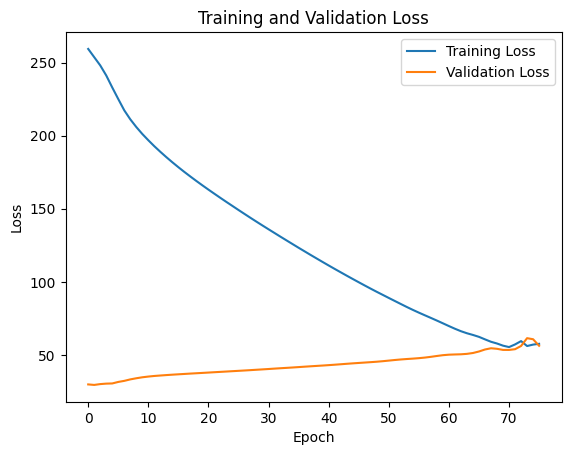

Model saved to models/gcn_1l_graph.pth
Average Time per Epoch: 0.30s
Average CPU Usage: 16.60GB
Average Memory Usage: 4.87GB

Total Training Time: 22.90s
Max CPU Usage: 25.72GB
Max Memory Usage: 4.90GB


In [15]:
# Create model instances
gcn1_graph = GCN1Layer(num_features, num_classes)
print(gcn1_graph)
print(f"Total number of trainable parameters: {(gcn1_graph.count_parameters())*2}\n")
train_graph(gcn1_graph, train_loader, val_loader, lr=0.01, num_epochs=150, save_path='models/gcn_1l_graph.pth')

#### GCN 2-Layer

GCN2Layer(
  (gcn1): GCN (32 -> 64)
  (gcn2): GCN (64 -> 64)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Total number of trainable parameters: 12934

Epoch 1, Train Loss: 1372.4067449569702, Val Loss: 57.62420082092285
Time: 0.14s, CPU: 1.76GB, Memory: 4.86GB
Epoch 2, Train Loss: 316.27241945266724, Val Loss: 29.75458574295044
Time: 1.02s, CPU: 25.34GB, Memory: 4.87GB
Epoch 3, Train Loss: 248.9487316608429, Val Loss: 30.549180507659912
Time: 0.44s, CPU: 23.37GB, Memory: 4.87GB
Epoch 4, Train Loss: 242.4301860332489, Val Loss: 30.827796578407288
Time: 1.41s, CPU: 25.34GB, Memory: 4.85GB
Epoch 5, Train Loss: 235.3697921037674, Val Loss: 30.509439826011658
Time: 1.19s, CPU: 24.72GB, Memory: 4.86GB
Epoch 6, Train Loss: 227.66747081279755, Val Loss: 30.587579011917114
Time: 0.36s, CPU: 20.44GB, Memory: 4.85GB
Epoch 7, Train Loss: 222.37258887290955, Val Loss: 29.788622975349426
Time: 0.17s, CPU: 15.09GB, Memory: 4.85GB
Epoch 8, Train Loss: 217.72940695285797, Val Loss: 29.29

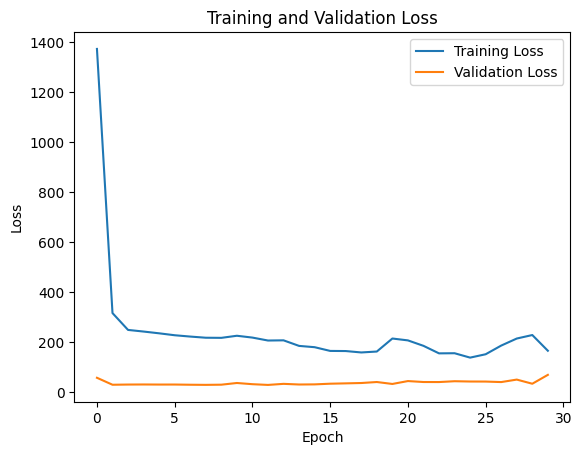

Model saved to models/gcn_2l_graph.pth
Average Time per Epoch: 0.27s
Average CPU Usage: 15.21GB
Average Memory Usage: 4.86GB

Total Training Time: 7.97s
Max CPU Usage: 25.34GB
Max Memory Usage: 4.87GB


In [16]:
gcn2_graph = GCN2Layer(num_features, num_classes)
print(gcn2_graph)
print(f"Total number of trainable parameters: {(gcn2_graph.count_parameters())*2}\n")
train_graph(gcn2_graph, train_loader, val_loader, lr=0.01, num_epochs=150, save_path='models/gcn_2l_graph.pth')

### GCESN

#### Variant 1

##### Single Run

GCESN_var1(
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 99

Epoch 1, Train Loss: 258.20654821395874, Val Loss: 30.3676518201828
Time: 0.37s, CPU: 1.59GB, Memory: 4.87GB
Epoch 2, Train Loss: 255.36606740951538, Val Loss: 30.11784267425537
Time: 0.74s, CPU: 25.19GB, Memory: 4.88GB
Epoch 3, Train Loss: 254.82725977897644, Val Loss: 29.82990539073944
Time: 0.92s, CPU: 25.02GB, Memory: 4.88GB
Epoch 4, Train Loss: 254.16612672805786, Val Loss: 29.919313073158264
Time: 0.72s, CPU: 24.22GB, Memory: 4.86GB
Epoch 5, Train Loss: 253.5511269569397, Val Loss: 30.059372663497925
Time: 0.58s, CPU: 23.26GB, Memory: 4.86GB
Epoch 6, Train Loss: 253.12514305114746, Val Loss: 30.035271406173706
Time: 1.13s, CPU: 25.25GB, Memory: 4.86GB
Epoch 7, Train Loss: 252.6641981601715, Val Loss: 29.968716144561768
Time: 0.11s, CPU: 13.45GB, Memory: 4.86GB
Epoch 8, Train Loss: 252.24993419647217, Val Loss: 29.97088873386383
Time: 0.11s, CPU: 13.07GB, Memory: 4.86G

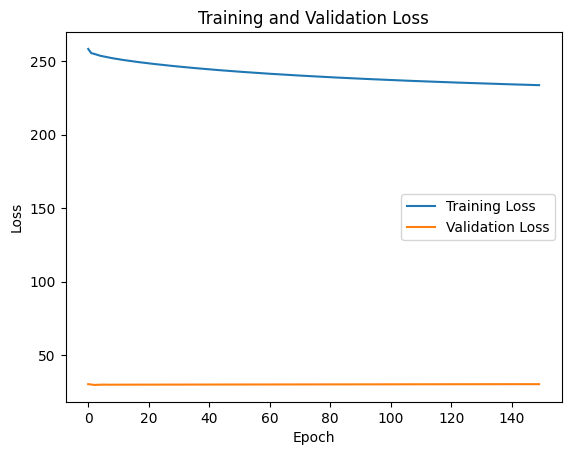

Model saved to models/gcesn_v1_graph.pth
Average Time per Epoch: 0.22s
Average CPU Usage: 16.18GB
Average Memory Usage: 4.86GB

Total Training Time: 32.70s
Max CPU Usage: 25.69GB
Max Memory Usage: 4.88GB


In [17]:
# Create model instances
gcesn1_graph = GCESN_var1(num_features, num_features, num_classes, num_iterations=1)
print(gcesn1_graph)
print(f"Total number of trainable parameters: {gcesn1_graph.count_parameters()}\n")
train_graph(gcesn1_graph, train_loader, val_loader, lr=0.01, num_epochs=150, save_path='models/gcesn_v1_graph.pth')

##### Multiple Runs

In [27]:
gcesn1_graph = GCESN_var1(num_features, num_features, num_classes, num_iterations=1)
train_and_evaluate_multiple_runs_graph(gcesn1_graph, train_loader, val_loader, test_loader, path='models/multiple_run/gcesn_v1_graph_')


Run 1/50 -> Loss: 225.19067585468292
  Total Training Time: 124.99s, Avg CPU Usage: 16.64GB, Avg Memory Usage: 4.91GB, Max CPU Usage: 26.19GB, Max Memory Usage: 4.94GB
  Accuracy: 0.4091, Sensitivity: 0.4167, Specificity: 0.7054
Early stopping at epoch 8

Run 2/50 -> Loss: 225.02157282829285
  Total Training Time: 0.99s, Avg CPU Usage: 15.43GB, Avg Memory Usage: 4.90GB, Max CPU Usage: 18.12GB, Max Memory Usage: 4.91GB
  Accuracy: 0.4242, Sensitivity: 0.4306, Specificity: 0.7133
Early stopping at epoch 8

Run 3/50 -> Loss: 224.8663650751114
  Total Training Time: 0.99s, Avg CPU Usage: 15.55GB, Avg Memory Usage: 4.91GB, Max CPU Usage: 17.06GB, Max Memory Usage: 4.91GB
  Accuracy: 0.4242, Sensitivity: 0.4306, Specificity: 0.7133
Early stopping at epoch 8

Run 4/50 -> Loss: 224.7219191789627
  Total Training Time: 0.95s, Avg CPU Usage: 14.65GB, Avg Memory Usage: 4.91GB, Max CPU Usage: 16.00GB, Max Memory Usage: 4.91GB
  Accuracy: 0.4091, Sensitivity: 0.4167, Specificity: 0.7063
Early stop

#### Variant 2

##### Single Run

GCESN_var2(
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 99

Epoch 1, Train Loss: 258.2204055786133, Val Loss: 30.365756034851074
Time: 0.12s, CPU: 2.61GB, Memory: 4.87GB
Epoch 2, Train Loss: 255.359459400177, Val Loss: 30.06373393535614
Time: 0.12s, CPU: 14.98GB, Memory: 4.87GB
Epoch 3, Train Loss: 254.80911445617676, Val Loss: 29.785739064216614
Time: 0.13s, CPU: 18.03GB, Memory: 4.87GB
Epoch 4, Train Loss: 254.1358561515808, Val Loss: 29.895472526550293
Time: 0.15s, CPU: 17.06GB, Memory: 4.88GB
Epoch 5, Train Loss: 253.51432371139526, Val Loss: 30.02510690689087
Time: 0.11s, CPU: 13.21GB, Memory: 4.88GB
Epoch 6, Train Loss: 253.07156896591187, Val Loss: 29.977219820022583
Time: 0.12s, CPU: 15.80GB, Memory: 4.88GB
Epoch 7, Train Loss: 252.5889618396759, Val Loss: 29.906947016716003
Time: 0.11s, CPU: 14.68GB, Memory: 4.88GB
Epoch 8, Train Loss: 252.1678342819214, Val Loss: 29.91348087787628
Time: 0.12s, CPU: 15.80GB, Memory: 4.88GB


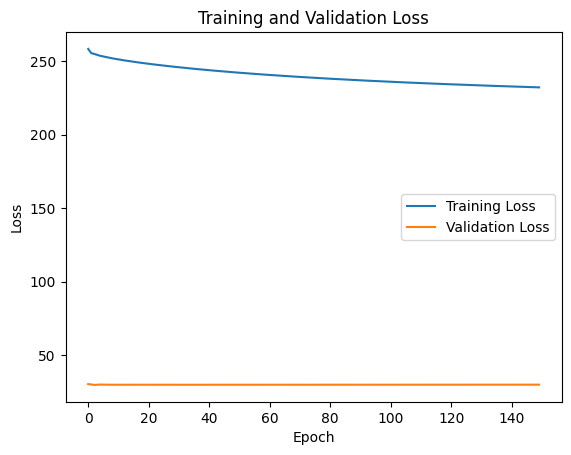

Model saved to models/gcesn_v2_graph.pth
Average Time per Epoch: 0.16s
Average CPU Usage: 15.78GB
Average Memory Usage: 4.88GB

Total Training Time: 23.46s
Max CPU Usage: 25.90GB
Max Memory Usage: 4.89GB


In [18]:
# Create model instances
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=1)
print(gcesn2_graph)
print(f"Total number of trainable parameters: {gcesn2_graph.count_parameters()}\n")
train_graph(gcesn2_graph, train_loader, val_loader, lr=0.01, num_epochs=150, save_path='models/gcesn_v2_graph.pth')

#### Multiple Runs

In [29]:
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=1)
train_and_evaluate_multiple_runs_graph(gcesn2_graph, train_loader, val_loader, test_loader, path='models/multiple_run/gcesn_v2_graph_')


Run 1/50 -> Loss: 220.70803344249725
  Total Training Time: 118.01s, Avg CPU Usage: 16.63GB, Avg Memory Usage: 4.92GB, Max CPU Usage: 26.22GB, Max Memory Usage: 4.95GB
  Accuracy: 0.3485, Sensitivity: 0.3704, Specificity: 0.6776
Early stopping at epoch 8

Run 2/50 -> Loss: 220.56473660469055
  Total Training Time: 0.90s, Avg CPU Usage: 14.15GB, Avg Memory Usage: 4.94GB, Max CPU Usage: 16.00GB, Max Memory Usage: 4.94GB
  Accuracy: 0.3485, Sensitivity: 0.3704, Specificity: 0.6776
Early stopping at epoch 8

Run 3/50 -> Loss: 220.42045998573303
  Total Training Time: 1.01s, Avg CPU Usage: 16.09GB, Avg Memory Usage: 4.93GB, Max CPU Usage: 19.82GB, Max Memory Usage: 4.94GB
  Accuracy: 0.3485, Sensitivity: 0.3704, Specificity: 0.6776
Early stopping at epoch 8

Run 4/50 -> Loss: 220.28846049308777
  Total Training Time: 3.38s, Avg CPU Usage: 18.74GB, Avg Memory Usage: 4.93GB, Max CPU Usage: 25.58GB, Max Memory Usage: 4.94GB
  Accuracy: 0.3485, Sensitivity: 0.3704, Specificity: 0.6776
Early st

### GCN-ESN

#### Variant 1

##### Single Run

GCNESN_var1(
  (gcn1): GCN (32 -> 64)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Total number of trainable parameters: 2307

Epoch 1, Train Loss: 262.7918086051941, Val Loss: 29.73852789402008
Time: 0.17s, CPU: 1.50GB, Memory: 4.89GB
Epoch 2, Train Loss: 246.3442553281784, Val Loss: 29.71355438232422
Time: 0.20s, CPU: 20.35GB, Memory: 4.90GB
Epoch 3, Train Loss: 235.49909853935242, Val Loss: 30.607850074768066
Time: 0.14s, CPU: 15.77GB, Memory: 4.90GB
Epoch 4, Train Loss: 221.56777167320251, Val Loss: 31.079131364822388
Time: 0.13s, CPU: 16.18GB, Memory: 4.90GB
Epoch 5, Train Loss: 210.8260692358017, Val Loss: 32.390239119529724
Time: 0.19s, CPU: 17.35GB, Memory: 4.90GB
Epoch 6, Train Loss: 199.32302391529083, Val Loss: 33.06702482700348
Time: 0.14s, CPU: 15.50GB, Memory: 4.90GB
Epoch 7, Train Loss: 190.31244122982025, Val Loss: 34.03151607513428
Time: 0.13s, CPU: 16.77GB, Memory: 4.90GB
Epoch 8, Train Loss: 180.5043540596962, Val Loss: 34.6292839050293
Time: 0.12s, CP

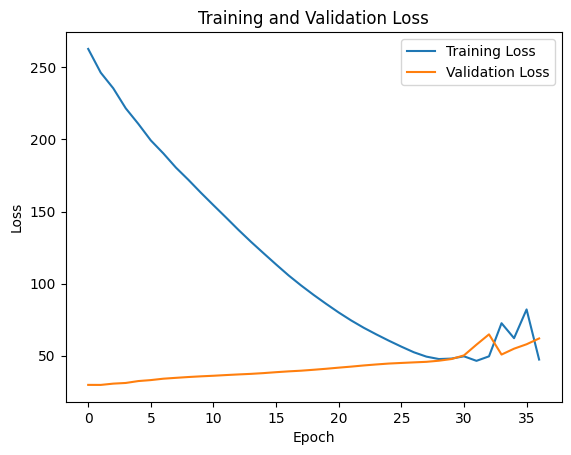

Model saved to models/gcnesn_v1_graph.pth
Average Time per Epoch: 0.28s
Average CPU Usage: 17.86GB
Average Memory Usage: 4.89GB

Total Training Time: 10.43s
Max CPU Usage: 26.22GB
Max Memory Usage: 4.92GB


In [19]:
# Create model instances
gcnesn1_graph = GCNESN_var1(num_features, 64, num_classes)
print(gcnesn1_graph)
print(f"Total number of trainable parameters: {gcnesn1_graph.count_parameters()}\n")
train_graph(gcnesn1_graph, train_loader, val_loader, lr=0.01, num_epochs=150, save_path='models/gcnesn_v1_graph.pth')

##### Multiple Runs

In [30]:
# Create model instances
gcnesn1_graph = GCNESN_var1(num_features, 64, num_classes)
train_and_evaluate_multiple_runs_graph(gcnesn1_graph, train_loader, val_loader, test_loader, path='models/multiple_run/gcnesn_v1_graph_')


Run 1/50 -> Loss: 0.14876298772287555
  Total Training Time: 135.17s, Avg CPU Usage: 18.22GB, Avg Memory Usage: 4.92GB, Max CPU Usage: 25.90GB, Max Memory Usage: 4.94GB
  Accuracy: 0.3788, Sensitivity: 0.3889, Specificity: 0.6895

Run 2/50 -> Loss: 0.0023145509162532107
  Total Training Time: 108.37s, Avg CPU Usage: 17.96GB, Avg Memory Usage: 4.92GB, Max CPU Usage: 25.99GB, Max Memory Usage: 4.94GB
  Accuracy: 0.3788, Sensitivity: 0.3889, Specificity: 0.6895
Early stopping at epoch 10

Run 3/50 -> Loss: 0.17619267938425764
  Total Training Time: 1.47s, Avg CPU Usage: 17.85GB, Avg Memory Usage: 4.92GB, Max CPU Usage: 19.38GB, Max Memory Usage: 4.92GB
  Accuracy: 0.3788, Sensitivity: 0.3843, Specificity: 0.6925

Run 4/50 -> Loss: 0.0010076727403429686
  Total Training Time: 136.81s, Avg CPU Usage: 18.54GB, Avg Memory Usage: 4.92GB, Max CPU Usage: 26.25GB, Max Memory Usage: 4.95GB
  Accuracy: 0.3788, Sensitivity: 0.3889, Specificity: 0.6905
Early stopping at epoch 11

Run 5/50 -> Loss: 7

#### Variant 2

##### Single Run

GCNESN_var2(
  (gcn1): GCN (32 -> 64)
  (gcn2): GCN (64 -> 64)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Total number of trainable parameters: 6467

Epoch 1, Train Loss: 3644.616912841797, Val Loss: 142.89527320861816
Time: 0.13s, CPU: 1.79GB, Memory: 4.88GB
Epoch 2, Train Loss: 837.3751540184021, Val Loss: 38.499534487724304
Time: 0.18s, CPU: 12.77GB, Memory: 4.88GB
Epoch 3, Train Loss: 268.7682454586029, Val Loss: 33.21418797969818
Time: 0.17s, CPU: 15.86GB, Memory: 4.88GB
Epoch 4, Train Loss: 232.13850569725037, Val Loss: 30.18101191520691
Time: 0.19s, CPU: 18.00GB, Memory: 4.88GB
Epoch 5, Train Loss: 225.13730025291443, Val Loss: 30.922006487846375
Time: 0.14s, CPU: 16.27GB, Memory: 4.88GB
Epoch 6, Train Loss: 212.56613838672638, Val Loss: 32.818750977516174
Time: 0.13s, CPU: 16.77GB, Memory: 4.88GB
Epoch 7, Train Loss: 207.82034361362457, Val Loss: 32.42970299720764
Time: 0.13s, CPU: 15.24GB, Memory: 4.88GB
Epoch 8, Train Loss: 197.18544334173203, Val Loss: 31.49

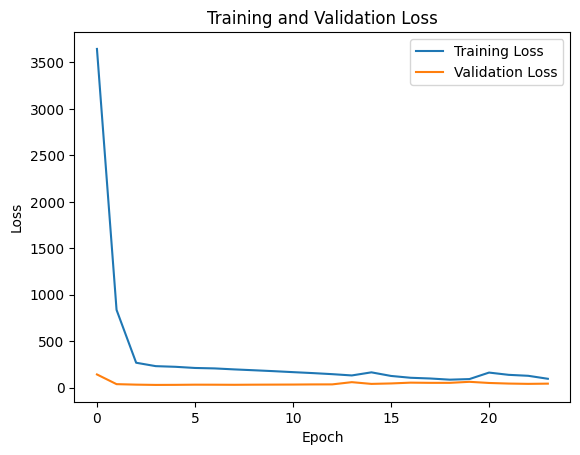

Model saved to models/gcnesn_v2_graph.pth
Average Time per Epoch: 0.16s
Average CPU Usage: 15.91GB
Average Memory Usage: 4.88GB

Total Training Time: 3.82s
Max CPU Usage: 21.29GB
Max Memory Usage: 4.88GB


In [20]:
# Create model instances
gcnesn2_graph = GCNESN_var2(num_features, 64, num_classes)
print(gcnesn2_graph)
print(f"Total number of trainable parameters: {gcnesn2_graph.count_parameters()}\n")
train_graph(gcnesn2_graph, train_loader, val_loader, lr=0.01, num_epochs=150, save_path='models/gcnesn_v2_graph.pth')

##### Multiple Runs

In [31]:
# Create model instances
gcnesn2_graph = GCNESN_var2(num_features, 64, num_classes)
train_and_evaluate_multiple_runs_graph(gcnesn2_graph, train_loader, val_loader, test_loader, path='models/multiple_run/gcnesn_v2_graph_')

Early stopping at epoch 22

Run 1/50 -> Loss: 214.74221885204315
  Total Training Time: 8.73s, Avg CPU Usage: 18.28GB, Avg Memory Usage: 4.93GB, Max CPU Usage: 25.63GB, Max Memory Usage: 4.96GB
  Accuracy: 0.3333, Sensitivity: 0.3333, Specificity: 0.6667
Early stopping at epoch 12

Run 2/50 -> Loss: 128.5904816389084
  Total Training Time: 1.75s, Avg CPU Usage: 16.27GB, Avg Memory Usage: 4.93GB, Max CPU Usage: 18.59GB, Max Memory Usage: 4.93GB
  Accuracy: 0.3485, Sensitivity: 0.3380, Specificity: 0.6627
Early stopping at epoch 27

Run 3/50 -> Loss: 14.274196512415074
  Total Training Time: 4.15s, Avg CPU Usage: 16.46GB, Avg Memory Usage: 4.93GB, Max CPU Usage: 19.53GB, Max Memory Usage: 4.94GB
  Accuracy: 0.3182, Sensitivity: 0.3241, Specificity: 0.6627

Run 4/50 -> Loss: 0.00043070147148682736
  Total Training Time: 103.46s, Avg CPU Usage: 16.86GB, Avg Memory Usage: 4.93GB, Max CPU Usage: 25.90GB, Max Memory Usage: 4.96GB
  Accuracy: 0.3939, Sensitivity: 0.3935, Specificity: 0.6974

R

# Evaluation

## Predictive Performance

In [21]:
print('Model 1-Layer GCN')
gcn1_graph = GCN1Layer(num_features, num_classes)
gcn1_graph.load_state_dict(torch.load('models/gcn_1l_graph.pth'))
test_graph(gcn1_graph, test_loader)

print('\nModel 2-Layer GCN')
gcn2_graph = GCN2Layer(num_features, num_classes)
gcn2_graph.load_state_dict(torch.load('models/gcn_2l_graph.pth'))
test_graph(gcn2_graph, test_loader)

print('\nModel GCESN Var-1')
gcesn1_graph = GCESN_var1(num_features, num_features, num_classes, num_iterations=6)
gcesn1_graph.load_state_dict(torch.load('models/gcesn_v1_graph.pth'))
test_graph(gcesn1_graph, test_loader)

print('\nModel GCESN Var-2')
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=6)
gcesn2_graph.load_state_dict(torch.load('models/gcesn_v2_graph.pth'))
test_graph(gcesn2_graph, test_loader)

print('\nModel GCNESN Var-1')
gcnesn1_graph = GCNESN_var1(num_features, 64, num_classes)
gcnesn1_graph.load_state_dict(torch.load('models/gcnesn_v1_graph.pth'))
test_graph(gcnesn1_graph, test_loader)

print('\nModel GCNESN Var-2')
gcnesn2_graph = GCNESN_var2(num_features, 64, num_classes)
gcnesn2_graph.load_state_dict(torch.load('models/gcnesn_v2_graph.pth'))
test_graph(gcnesn2_graph, test_loader)

Model 1-Layer GCN
Confusion Matrix:
[[ 7 10  7]
 [ 7  6 11]
 [ 3  9  6]]
Accuracy: 0.2879
Average Sensitivity (Recall): 0.2917
Average Specificity: 0.6448

Model 2-Layer GCN
Confusion Matrix:
[[ 1 12 11]
 [ 1  8 15]
 [ 0  7 11]]
Accuracy: 0.3030
Average Sensitivity (Recall): 0.3287
Average Specificity: 0.6607

Model GCESN Var-1
Confusion Matrix:
[[ 0 17  7]
 [ 0 21  3]
 [ 0 15  3]]
Accuracy: 0.3636
Average Sensitivity (Recall): 0.3472
Average Specificity: 0.6766

Model GCESN Var-2
Confusion Matrix:
[[ 0 18  6]
 [ 0 19  5]
 [ 0 15  3]]
Accuracy: 0.3333
Average Sensitivity (Recall): 0.3194
Average Specificity: 0.6617

Model GCNESN Var-1
Confusion Matrix:
[[ 7  5 12]
 [ 5  8 11]
 [ 3  5 10]]
Accuracy: 0.3788
Average Sensitivity (Recall): 0.3935
Average Specificity: 0.6974

Model GCNESN Var-2
Confusion Matrix:
[[10  8  6]
 [ 9  8  7]
 [ 3  9  6]]
Accuracy: 0.3636
Average Sensitivity (Recall): 0.3611
Average Specificity: 0.6796


## Inference Consumption

In [32]:
def measure_inference_performance(model, loader):
    model.to(device)
    model.eval()
    inference_times = []
    cpu_usages = []
    memory_usages = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            start_time = time.time()
            cpu_start = psutil.cpu_percent(interval=None)
            mem_start = psutil.virtual_memory().used

            output = model(x, adj_matrix, batch)

            cpu_end = psutil.cpu_percent(interval=None)
            mem_end = psutil.virtual_memory().used
            end_time = time.time()

            inference_times.append(end_time - start_time)
            cpu_usages.append((cpu_end - cpu_start) / 100 * psutil.virtual_memory().total / (1024**2))
            memory_usages.append((mem_end - mem_start) / (1024**2))

    avg_inference_time = np.mean(inference_times)
    avg_cpu_usage = np.mean(cpu_usages)
    avg_memory_usage = np.mean(memory_usages)

    print(f'Average Inference Time: {avg_inference_time:.6f}s')
    print(f'Average CPU Usage: {avg_cpu_usage:.6f}MB')
    print(f'Average Memory Usage: {avg_memory_usage:.6f}MB')

    return
    # return avg_inference_time, avg_cpu_usage, avg_memory_usage

In [33]:
print('\nInference 1-Layer GCN:')
measure_inference_performance(gcn1_graph, test_loader)

print('\nInference 2-Layer GCN:')
measure_inference_performance(gcn2_graph, test_loader)

print('\nInference GCESN Var-1:')
measure_inference_performance(gcesn1_graph, test_loader)

print('\nInference GCESN Var-2:')
measure_inference_performance(gcesn2_graph, test_loader)

print('\nInference GCNESN Var-1:')
measure_inference_performance(gcnesn1_graph, test_loader)

print('\nInference GCNESN Var-2:')
measure_inference_performance(gcnesn2_graph, test_loader)


Inference 1-Layer GCN:
Average Inference Time: 0.002107s
Average CPU Usage: -3417.743542MB
Average Memory Usage: 0.204427MB

Inference 2-Layer GCN:
Average Inference Time: 0.002074s
Average CPU Usage: -17028.581458MB
Average Memory Usage: -0.041667MB

Inference GCESN Var-1:
Average Inference Time: 0.002411s
Average CPU Usage: -4951.217917MB
Average Memory Usage: 0.000000MB

Inference GCESN Var-2:
Average Inference Time: 0.001766s
Average CPU Usage: -20606.688333MB
Average Memory Usage: 0.000000MB

Inference GCNESN Var-1:
Average Inference Time: 0.005156s
Average CPU Usage: 571.294375MB
Average Memory Usage: 0.000000MB

Inference GCNESN Var-2:
Average Inference Time: 0.004839s
Average CPU Usage: -10353.457708MB
Average Memory Usage: 0.000000MB
